## Packages

In [2]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 4.9 MB/s 
     |████████████████████████████████| 5.5 MB 56.0 MB/s 
     |████████████████████████████████| 1.3 MB 56.7 MB/s 
     |████████████████████████████████| 163 kB 69.9 MB/s 
     |████████████████████████████████| 7.6 MB 55.9 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=23d93d324f2536a7f0741ef5780300330c5f325ed7ee4691850453a279b3dd5f
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers


In [2]:
!mkdir GloVe
!curl -Lo GloVe/glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
!unzip GloVe/glove.840B.300d.zip -d GloVe/
!mkdir fastText
!curl -Lo fastText/crawl-300d-2M.vec.zip https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip fastText/crawl-300d-2M.vec.zip -d fastText/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   315    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   353    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2075M  100 2075M    0     0  5166k      0  0:06:51  0:06:51 --:--:-- 5116k
Archive:  GloVe/glove.840B.300d.zip
  inflating: GloVe/glove.840B.300d.txt  
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1453M  100 1453M    0     0  19.6M      0  0:01:14  0:01:14 --:--:-- 23.5M
Archive:  fastText/crawl-300d-2M.vec.zip
  inflating: fastText/crawl-300d-2M.vec  


In [3]:
!mkdir encoder
!curl -Lo encoder/infersent1.pkl https://dl.fbaipublicfiles.com/infersent/infersent1.pkl
!curl -Lo encoder/infersent2.pkl https://dl.fbaipublicfiles.com/infersent/infersent2.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  18.6M      0  0:00:07  0:00:07 --:--:-- 25.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  146M  100  146M    0     0  17.5M      0  0:00:08  0:00:08 --:--:-- 23.1M


In [2]:
import numpy as np
import pandas as pd

# from sentence_transformers import SentenceTransformer
import torch
import nltk
nltk.download('punkt')
# from InferSentmain.models import InferSent
import tensorflow as tf
import tensorflow_hub as hub

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import DBSCAN, KMeans
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

# from clustering_utils import KMeans as KustomKmeans

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Data Generation

In [3]:
column_names = ["question", "label_info", "source"]

In [4]:
exp_data = pd.read_csv("Datasets/Experimental Data for Question Classification train_5500.label.txt", \
                       sep='\t', \
                       encoding = "ISO-8859-1", \
                       header=None)  
exp_data = exp_data[0].str.split(" ", 1, expand=True)
exp_data = exp_data[[1, 0]]
exp_data["source"] = "experiemntal_qna_classification"
exp_data.columns = column_names
exp_data.head()

,question,label_info,source
0,How did serfdom develop in and then leave Russ...,DESC:manner,experiemntal_qna_classification
1,What films featured the character Popeye Doyle ?,ENTY:cremat,experiemntal_qna_classification
2,How can I find a list of celebrities ' real na...,DESC:manner,experiemntal_qna_classification
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,experiemntal_qna_classification
4,What is the full form of .com ?,ABBR:exp,experiemntal_qna_classification


In [5]:
final_data = exp_data
final_data.head()

,question,label_info,source
0,How did serfdom develop in and then leave Russ...,DESC:manner,experiemntal_qna_classification
1,What films featured the character Popeye Doyle ?,ENTY:cremat,experiemntal_qna_classification
2,How can I find a list of celebrities ' real na...,DESC:manner,experiemntal_qna_classification
3,What fowl grabs the spotlight after the Chines...,ENTY:animal,experiemntal_qna_classification
4,What is the full form of .com ?,ABBR:exp,experiemntal_qna_classification


In [6]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5452 entries, 0 to 5451
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   question    5452 non-null   object
 1   label_info  5452 non-null   object
 2   source      5452 non-null   object
dtypes: object(3)
memory usage: 127.9+ KB


In [7]:
print(len(np.unique(final_data["label_info"].str.split(":", expand=True)[0].to_numpy())))
print(np.unique(final_data["label_info"].str.split(":", expand=True)[0].to_numpy()))

6
['ABBR' 'DESC' 'ENTY' 'HUM' 'LOC' 'NUM']


In [14]:
print(len(np.unique(final_data["label_info"].to_numpy())))
print(np.unique(final_data["label_info"].to_numpy()))

50
['ABBR:abb' 'ABBR:exp' 'DESC:def' 'DESC:desc' 'DESC:manner' 'DESC:reason'
 'ENTY:animal' 'ENTY:body' 'ENTY:color' 'ENTY:cremat' 'ENTY:currency'
 'ENTY:dismed' 'ENTY:event' 'ENTY:food' 'ENTY:instru' 'ENTY:lang'
 'ENTY:letter' 'ENTY:other' 'ENTY:plant' 'ENTY:product' 'ENTY:religion'
 'ENTY:sport' 'ENTY:substance' 'ENTY:symbol' 'ENTY:techmeth' 'ENTY:termeq'
 'ENTY:veh' 'ENTY:word' 'HUM:desc' 'HUM:gr' 'HUM:ind' 'HUM:title'
 'LOC:city' 'LOC:country' 'LOC:mount' 'LOC:other' 'LOC:state' 'NUM:code'
 'NUM:count' 'NUM:date' 'NUM:dist' 'NUM:money' 'NUM:ord' 'NUM:other'
 'NUM:perc' 'NUM:period' 'NUM:speed' 'NUM:temp' 'NUM:volsize' 'NUM:weight']


## Sentence Transformer Model - all-mpnet-base-v2

In [15]:
sentTransformerModel = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

### Generate Embeddings

In [16]:
questionEmbeddingsST1 = sentTransformerModel.encode(final_data["question"].to_numpy())

In [17]:
questionEmbeddingsST1.shape

(5452, 768)

In [18]:
np.save(file="qna_5500_embeddings_ST1", arr = questionEmbeddingsST1)

### Visualization

In [20]:
pca = PCA(n_components=3)
dimReducer = pca.fit(questionEmbeddingsST1)
X_r = dimReducer.transform(X=questionEmbeddingsST1)
# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r2 = lda.fit(X, y).transform(X)

In [21]:
print(pca.explained_variance_ratio_)

[0.03767506 0.03317153 0.0208281 ]


In [22]:
print(pca.singular_values_)

[13.40073  12.574313  9.96383 ]


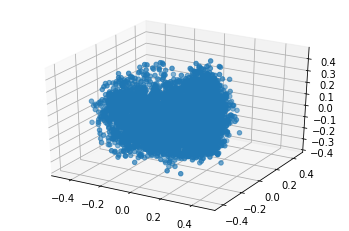

In [23]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_r[:,0], X_r[:,1],X_r[:,2])
plt.show()

## Sentence Transformer Model - multi-qa-mpnet-base-dot-v1

In [43]:
sentTransformerModel = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-dot-v1')

Downloading:   0%|          | 0.00/737 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

### Generate Embeddings

In [46]:
questionEmbeddingsST2 = sentTransformerModel.encode(final_data["question"].to_numpy())

In [47]:
questionEmbeddingsST2.shape

(5452, 768)

In [48]:
np.save(file="qna_5500_embeddings_ST2", arr = questionEmbeddingsST2)

### Visualization

In [49]:
pca = PCA(n_components=3)
dimReducer = pca.fit(questionEmbeddingsST2)
X_r = dimReducer.transform(X=questionEmbeddingsST2)
# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r2 = lda.fit(X, y).transform(X)

In [50]:
print(pca.explained_variance_ratio_)

[0.03975151 0.03233455 0.02297887]


In [51]:
print(pca.singular_values_)

[65.60292  59.167034 49.878193]


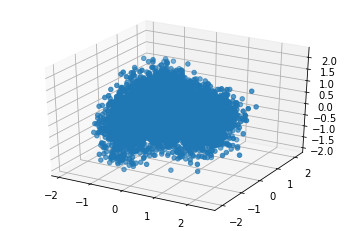

In [52]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_r[:,0], X_r[:,1],X_r[:,2])
plt.show()

## Sentence Transformer Model - nq-distilbert-base-v1

In [53]:
sentTransformerModel = SentenceTransformer('nq-distilbert-base-v1')

Downloading:   0%|          | 0.00/690 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.69k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/540 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/554 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

### Generate Embeddings

In [54]:
questionEmbeddingsST3 = sentTransformerModel.encode(final_data["question"].to_numpy())

In [55]:
questionEmbeddingsST3.shape

(5452, 768)

In [56]:
np.save(file="qna_5500_embeddings_ST3", arr = questionEmbeddingsST3)

### Visualization

In [57]:
pca = PCA(n_components=3)
dimReducer = pca.fit(questionEmbeddingsST1)
X_r = dimReducer.transform(X=questionEmbeddingsST1)
# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r2 = lda.fit(X, y).transform(X)

In [58]:
print(pca.explained_variance_ratio_)

[0.03975156 0.03233458 0.02297915]


In [59]:
print(pca.singular_values_)

[65.60296  59.167065 49.878494]


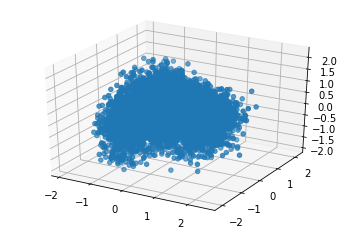

In [60]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_r[:,0], X_r[:,1],X_r[:,2])
plt.show()

## Universal Sentence Encoder - USE

In [62]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


### Generate Embeddings

In [63]:
questionEmbeddingsUSE = embed(final_data["question"].to_numpy())

In [64]:
questionEmbeddingsUSE.shape

TensorShape([5452, 512])

In [65]:
np.save(file="qna_5500_embeddings_USE", arr = questionEmbeddingsUSE)

### Visualization

In [12]:
pca = PCA(n_components=3)
dimReducer = pca.fit(questionEmbeddingsUSE)
X_r = dimReducer.transform(X=questionEmbeddingsUSE)
# lda = LinearDiscriminantAnalysis(n_components=2)
# X_r2 = lda.fit(X, y).transform(X)

In [13]:
print(pca.explained_variance_ratio_)

[0.03727462 0.02554588 0.02065612]


In [14]:
print(pca.singular_values_)

[13.028988 10.786101  9.699033]


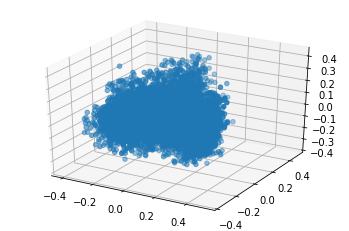

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_r[:,0], X_r[:,1],X_r[:,2])
plt.show()

## InferSent Model

In [28]:
V = 1
# V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent1 = InferSent(params_model)
infersent1.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'GloVe/glove.840B.300d.txt'
infersent1.set_w2v_path(W2V_PATH)

In [29]:
# V = 1
V = 2
MODEL_PATH = 'encoder/infersent%s.pkl' % V
params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
infersent2 = InferSent(params_model)
infersent2.load_state_dict(torch.load(MODEL_PATH))

W2V_PATH = 'fastText/crawl-300d-2M.vec'
infersent2.set_w2v_path(W2V_PATH)

In [30]:
infersent1.build_vocab(final_data["question"].to_numpy(), tokenize=True)

Found 9231(/9436) words with w2v vectors
Vocab size : 9231


In [31]:
infersent2.build_vocab(final_data["question"].to_numpy(), tokenize=True)

Found 9243(/9436) words with w2v vectors
Vocab size : 9243


### Generate Embeddings

In [32]:
questionEmbeddingsIS1 = infersent1.encode(final_data["question"].to_numpy(), tokenize=True)
questionEmbeddingsIS2 = infersent2.encode(final_data["question"].to_numpy(), tokenize=True)

/content/InferSentmain/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


In [33]:
print(questionEmbeddingsIS1.shape)
print(questionEmbeddingsIS2.shape)

(5452, 4096)
(5452, 4096)


In [34]:
np.save(file="qna_5500_embeddings_IS1", arr = questionEmbeddingsIS1)
np.save(file="qna_5500_embeddings_IS2", arr = questionEmbeddingsIS2)

### Visualization

In [39]:
pca = PCA(n_components=3)
# dimReducer = pca.fit(questionEmbeddingsIS1)
# X_r = dimReducer.transform(X=questionEmbeddingsIS1)
dimReducer = pca.fit(questionEmbeddingsIS2)
X_r = dimReducer.transform(X=questionEmbeddingsIS2)

In [40]:
print(pca.explained_variance_ratio_)

[0.08990805 0.04769518 0.03513567]


In [41]:
print(pca.singular_values_)

[41.887466 30.508585 26.18538 ]


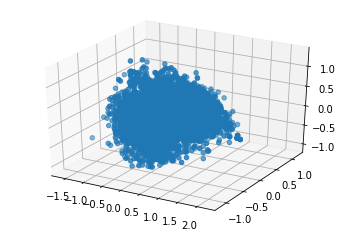

In [42]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_r[:,0], X_r[:,1],X_r[:,2])
plt.show()

## Clustering

### Load Emebddings if cached

In [10]:
questionEmbeddingsUSE = np.load("qna_5500_embeddings_USE.npy")
questionEmbeddingsST1 = np.load("qna_5500_embeddings_ST1.npy")
questionEmbeddingsST2 = np.load("qna_5500_embeddings_ST2.npy")
questionEmbeddingsST3 = np.load("qna_5500_embeddings_ST3.npy")
questionEmbeddingsIS1 = np.load("qna_5500_embeddings_IS1.npy")
questionEmbeddingsIS2 = np.load("qna_5500_embeddings_IS2.npy")

In [11]:
questionEmbeddings = questionEmbeddingsUSE
# questionEmbeddings = questionEmbeddingsST1
# questionEmbeddings = questionEmbeddingsST2
# questionEmbeddings = questionEmbeddingsST3
# questionEmbeddings = questionEmbeddingsIS1
# questionEmbeddings = questionEmbeddingsIS2
# questionEmbeddings = questionEmbeddingsD2V


### KMeans

In [16]:
X = questionEmbeddings
X = StandardScaler().fit_transform(X)

In [17]:
labels_true = final_data["label_info"].to_numpy()
K_clusters = 50 

# labels_true = final_data["label_info"].str.split(":", expand=True)[0].to_numpy()
# K_clusters = 6 

In [18]:
kmeans = KMeans(n_clusters=K_clusters, random_state=0).fit(X)
labels = kmeans.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 50
Estimated number of noise points: 0
Homogeneity: 0.507
Completeness: 0.421
V-measure: 0.460
Adjusted Rand Index: 0.182
Adjusted Mutual Information: 0.426
Silhouette Coefficient: 0.027


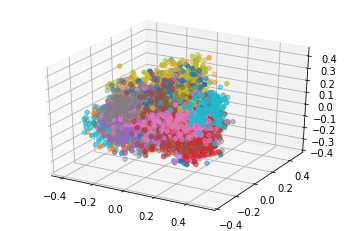

In [19]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

rough_df = pd.DataFrame(dict(x=X_r[:,0], y=X_r[:,1], z=X_r[:,2], label=labels))

groups = rough_df.groupby('label')

for name, group in groups: 
  ax.scatter(group.x, group.y, group.z, marker='o', label=name)
# ax.legend()
# ax.annotate("text", (z[1], y[1]), xytext=(z[1]-0.05, y[1]-0.3), 
#     arrowprops = dict(  arrowstyle="->",
#                         connectionstyle="angle3,angleA=0,angleB=-90"))

plt.show()

In [41]:
for name, group in groups: 
  unq_lbl,pos = np.unique(final_data.iloc[group.index]["label_info"].to_numpy(),return_inverse=True)
  print("Cluster " + str(name) + " -> Majority Class is " + str(unq_lbl[np.bincount(pos).argmax()]) + " with proportion " + str(np.bincount(pos).max()/np.bincount(pos).sum()))

Cluster 0 -> Majority Class is ENTY:other with proportion 0.2465753424657534
Cluster 1 -> Majority Class is ENTY:color with proportion 0.6557377049180327
Cluster 2 -> Majority Class is LOC:mount with proportion 0.4186046511627907
Cluster 3 -> Majority Class is DESC:def with proportion 0.7314814814814815
Cluster 4 -> Majority Class is HUM:ind with proportion 0.1702127659574468
Cluster 5 -> Majority Class is DESC:desc with proportion 0.54
Cluster 6 -> Majority Class is HUM:ind with proportion 0.5428571428571428
Cluster 7 -> Majority Class is HUM:ind with proportion 0.6444444444444445
Cluster 8 -> Majority Class is ABBR:exp with proportion 0.6911764705882353
Cluster 9 -> Majority Class is HUM:ind with proportion 0.6631578947368421
Cluster 10 -> Majority Class is LOC:city with proportion 0.7596899224806202
Cluster 11 -> Majority Class is ENTY:dismed with proportion 0.9253731343283582
Cluster 12 -> Majority Class is NUM:count with proportion 0.11904761904761904
Cluster 13 -> Majority Class 

In [108]:
for name, group in groups: 
  if name == 10:
    for ind in group.index:
      print(str(ind) + final_data.iloc[ind]["question"])

65Which city has the oldest relationship as a sisterðcity with Los Angeles ?
179What is the name of the city that Maurizio Pellegrin lives in ?
192Which Ventura County police department seized the largest cocaine shipment in it 's history ?
193What city is sometimes called Gotham ?
212What South American city has the world 's highest commercial landing field ?
265What European city do Nicois live in ?
298What city did the Flintstones live in ?
362Which city did Christian Crusaders fight to recapture from the Muslims ?
401What South Korean city is served by Kimpo International Airport ?
418What Nevada center has been dubbed The Biggest Little City in the World ?
488What U.S. city is The Queen of the Pacific ?
508McCarren Airport is located in what city ?
527What city is Logan Airport in ?
531What is the largest city on the Great Lakes ?
537What city gained renown for its pea-soup fogs ?
569What city is served by Logan International Airport ?
599In What city or state do the most gay men 

In [52]:
for name, group in groups: 
  if name == 17:
    print(final_data.iloc[group.index]["question"])

42            How many people in the world speak French ?
81      How many species of the Great White shark are ...
85      How many villi are found in the small intestine ?
117       How much money does a back injury lawsuit get ?
152     How many bends are there in a standard paper c...
                              ...                        
5316    How many small businesses are there in the Uni...
5349     How many men died building the Mackinaw Bridge ?
5367                 How many cullions does a male have ?
5373    What words in the English have two u 's back t...
5418    How many John Deere tractors have been manufac...
Name: question, Length: 191, dtype: object


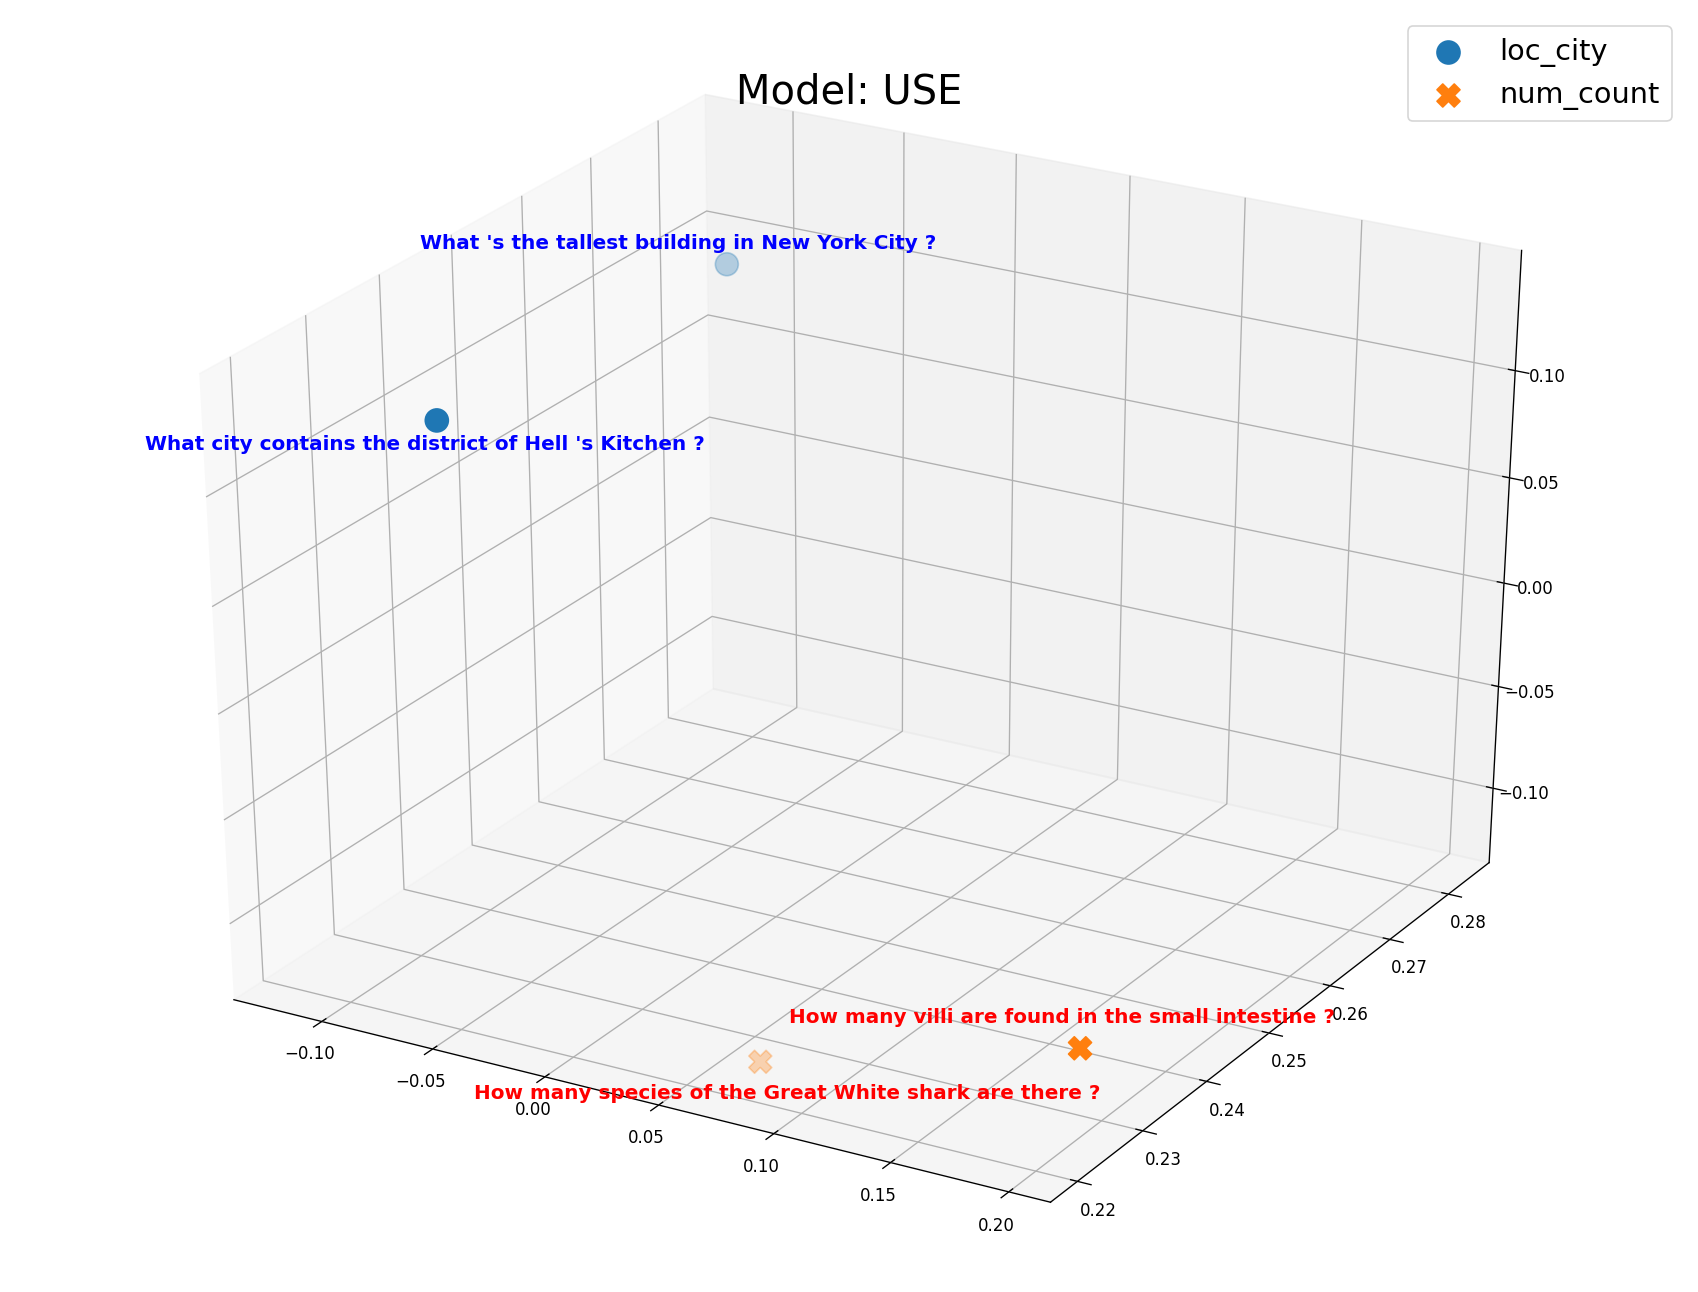

In [127]:
pca = PCA(n_components=3)
dimReducer = pca.fit(questionEmbeddings)
X_r = dimReducer.transform(X=questionEmbeddings)

fig = plt.figure(figsize=(18, 14), dpi=120)
ax = fig.add_subplot(projection='3d')
ax.set_title("Model: USE", fontsize=24)
#193,5385
ax.scatter(X_r[[656, 3085],0], X_r[[656, 3085],1],X_r[[656, 3085],2], marker='o', label="loc_city", s=190)
ax.scatter(X_r[[81, 85],0], X_r[[81, 85],1],X_r[[81, 85],2], marker='X', label="num_count", s=190)
ax.legend(fontsize="xx-large")
# ax.annotate("LOOOOOOOONG text", (X_r[81,0], X_r[81,1]), xytext=(X_r[81,0]-0.05, X_r[81,1]-0.3), 
#     arrowprops = dict(  arrowstyle="->",
#                         connectionstyle="angle3,angleA=0,angleB=-90"))
ax.text(X_r[656,0]-0.095, X_r[656,1]-0.015,  X_r[656,2]+0.015, final_data.iloc[656]["question"], color='blue', fontweight='bold', fontsize='large')
ax.text(X_r[3085,0]-0.095, X_r[3085,1]-0.01,  X_r[3085,2]-0.015, final_data.iloc[3085]["question"], color='blue', fontweight='bold', fontsize='large')
ax.text(X_r[81,0]-0.095, X_r[81,1]-0.01,  X_r[81,2]-0.02, final_data.iloc[81]["question"], color='red', fontweight='bold', fontsize='large')
ax.text(X_r[85,0]-0.095, X_r[85,1]-0.01,  X_r[85,2]+0.01, final_data.iloc[85]["question"], color='red', fontweight='bold', fontsize='large')

plt.show()

In [122]:
print("IntraBLUE "+str(np.linalg.norm(X_r[656,:] - X_r[3085,:])))
print("IntraRED "+str(np.linalg.norm(X_r[81,:] - X_r[85,:])))
print("Inter "+str(max(np.linalg.norm(X_r[81,:] - X_r[85,:]))))

BLUE 0.09335128
RED 0.11578224


In [121]:
X_r[3085,:].shape

(3,)

In [50]:
unique, counts = np.unique(labels, return_counts=True)
freq_chart = np.asarray((unique, counts)).T
freq_chart[freq_chart[:, 1].argsort()]
# freq_chart

array([[ 44,  26],
       [  4,  27],
       [ 22,  32],
       [ 19,  38],
       [ 25,  39],
       [ 14,  39],
       [  8,  39],
       [ 28,  39],
       [ 24,  40],
       [  2,  40],
       [ 39,  41],
       [ 45,  42],
       [  1,  42],
       [ 36,  43],
       [ 20,  49],
       [ 40,  50],
       [ 21,  50],
       [  5,  51],
       [ 32,  52],
       [ 47,  53],
       [ 41,  55],
       [ 13,  55],
       [ 18,  56],
       [  9,  56],
       [ 26,  57],
       [ 37,  58],
       [ 33,  58],
       [ 10,  59],
       [  3,  60],
       [ 31,  60],
       [ 11,  61],
       [ 46,  63],
       [ 34,  65],
       [ 43,  66],
       [ 49,  68],
       [ 42,  70],
       [ 27,  72],
       [ 17,  72],
       [ 38,  75],
       [  7,  75],
       [ 16,  76],
       [ 35,  78],
       [ 23,  81],
       [ 30,  81],
       [ 12,  87],
       [ 48,  90],
       [  6,  96],
       [  0,  99],
       [ 29, 106],
       [ 15, 113]])

In [52]:
(labels==15).shape

(3000,)

In [58]:
final_data.iloc[(labels==44),0:2]

,question,label_info
14,What is considered the costliest disaster the ...,ENTY:event
33,Which company that manufactures video-game har...,HUM:gr
128,What piano company claims its product is the `...,HUM:gr
165,Which Japanese car maker had its biggest perce...,HUM:gr
229,How much does a new railroad coal car cost ?,NUM:money
309,What is the fastest commercial automobile that...,ENTY:other
344,Who is the leading competitor of Trans Union C...,HUM:gr
381,What is the abbreviation of the company name `...,ABBR:abb
487,What stereo manufacturer is `` Slightly ahead ...,HUM:gr
499,Which oil company almost picked a word that me...,HUM:gr


## Kustom KMeans

In [60]:
X = questionEmbeddings
X = StandardScaler().fit_transform(X)

In [61]:
labels_true = final_data["label_info"].to_numpy()
K_clusters = 50 

# labels_true = final_data["label_info"].str.split(":", expand=True)[0].to_numpy()
# K_clusters = 6 

In [ ]:
kmeans = KustomKmeans(num_clusters=K_clusters, dist_fn="").fit(X)

In [65]:
# kmeans = KustomKmeans(num_clusters=K_clusters, dist_fn="").fit(X)
labels = kmeans.predict(X)#kmeans.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 50
Estimated number of noise points: 0
Homogeneity: 0.430
Completeness: 0.355
V-measure: 0.389
Adjusted Rand Index: 0.107
Adjusted Mutual Information: 0.323
Silhouette Coefficient: 0.033


In [64]:
kmeans.predict(X).shape

(3000,)

### DBSCAN

In [ ]:
X = questionEmbeddings
X = StandardScaler().fit_transform(X)
labels_true = final_data["label_info"].to_numpy()
# labels_true = final_data["label_info"].str.split(":", expand=True)[0].to_numpy()

In [ ]:
db = DBSCAN(eps=10.3, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print(
    "Adjusted Mutual Information: %0.3f"
    % metrics.adjusted_mutual_info_score(labels_true, labels)
)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))